## Given a set of findings, return the most likely rare diseases

Number of diseases imported from the ORDO database: 10,735  
Number of phenotypes imported from the HPO database: 10,653  
Number of disease-phenotype relations imported from the HOOM database: 108,638  

In [24]:
import getpass
password = getpass.getpass("\nPlease enter the Neo4j database password to continue \n")

from neo4j import GraphDatabase
driver=GraphDatabase.driver(uri="bolt://localhost:7687", auth=('neo4j',password))
session=driver.session()


Please enter the Neo4j database password to continue 
 ············


In [25]:
# Get a count of the number of rare diseases associated with each human phenotype entity, 
# and set that number as a property of the human phenotype entity
query = '''
MATCH (h:HPOentity)-[:ASSOC_WITH]-(o:OrphEntity)
WITH h, count(o) as Number
SET h.number_assoc_rare_diseases = Number
RETURN h.name, h.number_assoc_rare_diseases AS freq
ORDER BY freq DESC
'''
data = session.run(query)
hpo_frequencies = pd.DataFrame([dict(record) for record in data])

hpo_frequencies

,h.name,freq
0,Seizure,1024
1,Intellectual disability,862
2,Short stature,783
3,Global developmental delay,736
4,Microcephaly,590
...,...,...
6711,Abnormal molar morphology,1
6712,Abnormality of permanent molar morphology,1
6713,Localized hypoplasia of dental enamel,1
6714,Hypomature dental enamel,1


<AxesSubplot:>

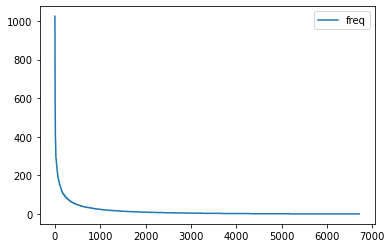

In [44]:
hpo_frequencies.plot()

In [30]:
# Get the maximum and minimum estimated prevalence values for each disease
# and set these as upper and lower estimate properties on each disease
query = '''
MATCH (n:OrphEntity)
UNWIND [n.point_prevalence, n.birth_prevalence, n.lifetime_prevalence] AS prev
WITH max(prev) AS max_prev, min(prev) AS min_prev, n
SET n.prevalence_estimate_upper = max_prev, n.prevalence_estimate_lower = min_prev
RETURN n.name, n.prevalence_estimate_upper, n.prevalence_estimate_lower
'''
data = session.run(query)
disease_prevalences = pd.DataFrame([dict(record) for record in data])
disease_prevalences

,n.name,n.prevalence_estimate_upper,n.prevalence_estimate_lower
0,"48,XXYY syndrome",0.000050,0.000050
1,Ataxia-telangiectasia,0.000175,0.000028
2,Ocular albinism with late-onset sensorineural ...,0.000001,0.000001
3,Reticular perineurioma,NaN,NaN
4,Sclerosing perineurioma,NaN,NaN
...,...,...,...
10730,Intermediate DEND syndrome,NaN,NaN
10731,Brill-Zinsser disease,NaN,NaN
10732,Relapsing epidemic typhus,NaN,NaN
10733,Complex regional pain syndrome type 2,NaN,NaN


In [32]:
# Find the number of phenotype relations which constitute diagnostic criteria
query = '''
MATCH (n:HPOentity)-[r:ASSOC_WITH]-(o:OrphEntity)
RETURN r.diagnostic_criterion_attribute, count(r)
'''
data = session.run(query)
pd.DataFrame([dict(record) for record in data])

,r.diagnostic_criterion_attribute,count(r)
0,None,107457
1,Exclusion_DC,633
2,Criterion_DC,541
3,Pathognomomic_DC,7


In [43]:
# Find the number of diseases with at least one diagnostic criterion
query = '''
MATCH (n:HPOentity)-[r:ASSOC_WITH]-(o:OrphEntity)
RETURN r.diagnostic_criterion_attribute, count(distinct(o))
'''
data = session.run(query)
pd.DataFrame([dict(record) for record in data])

,r.diagnostic_criterion_attribute,count(distinct(o))
0,None,4342
1,Exclusion_DC,319
2,Criterion_DC,170
3,Pathognomomic_DC,7


In [39]:
# Examine the pathognomonic findings and their corresponding diseases
query = '''
MATCH (n:HPOentity)-[r:ASSOC_WITH]-(o:OrphEntity)
WHERE r.diagnostic_criterion_attribute = 'Pathognomomic_DC'
RETURN n.name AS Finding, o.name AS Disease
'''
data = session.run(query)
pd.DataFrame([dict(record) for record in data])

,Finding,Disease
0,Ovarian gonadoblastoma,Gonadoblastoma
1,Ganglioneuroma,Ganglioneuroma
2,Remnants of the hyaloid vascular system,Persistent hyperplastic primary vitreous
3,Adrenocortical cytomegaly,Beckwith-Wiedemann syndrome
4,True hermaphroditism,"46,XY ovotesticular disorder of sex development"
5,Pituitary carcinoma,Pituitary carcinoma
6,Recurrent singultus,Chronic hiccup


Of the pathognomonic findings above, only adrenocortical cytomegaly may provide a non-obvious diagnosis. Looks like using pathognomonic findings from this dataset won't be much help in identifying kids with rare disease. Let's see where a more probabilistic approach takes us.

## Challenges

Given the findings associated with a single disease, identify which disease is the most likely diagnosis.  
Given the findings for two diseases mixed up in a single list, identify which two diseases are the most likely and which of the findings go with each disease.  
Given the findings for n diseases, find the minimum set of diseases which can account for the maximum number of findings.


Factors which increase the likelihood of a disease:
- the number of findings in the given list which match to a disease
- a higher prevalence of the disease in the general population

Factors which decrease the likelihood of a disease:
- findings in a given list which have "Exclusion_DC" in their connection to a disease
- the absence of findings which have a high approx_frequency of association between the finding and a disease

Factors which increase the weight of any given finding:
- a higher specificity of a given finding for a disease
- presence of the "Criterion_DC" or "Pathognomomic_DC" in their connection to a disease

## Approach
1. Get a list of diseases which have at least one finding in the list of given findings, and which are not excluded by the given findings
2. Calculate the likelihood of each disease:  
Likelihood of disease = (disease prevalence) X (specificity of present finding 1 + ...specificity of present finding n) X (number of "Criterion_DC" findings) / (approx_frequency of absent finding 1 + ...approx_frequency of absent finding n)  
-or-  
Likelihood of disease = (disease prevalence) X (number of findings positive in this patient) / (total number findings associated with the disease)  
3. Sort the list from most likely to least

In [115]:
# Get lists of findings associated with a couple of diseases
query = '''
MATCH (h:HPOentity)-[r:ASSOC_WITH]->(d:OrphEntity)
WHERE d.umls_id IN ["C2930971", "C0018854", "C1969443"]
RETURN d.name AS Disease, collect(h.name) as Findings'''
data = session.run(query)
disease_example = pd.DataFrame([dict(record) for record in data])
disease_example

,Disease,Findings
0,Gamma-heavy chain disease,"[Peripheral neuropathy, Recurrent respiratory ..."
1,Long chain 3-hydroxyacyl-CoA dehydrogenase def...,"[Peripheral neuropathy, Abnormality of metabol..."
2,Mitochondrial trifunctional protein deficiency,"[Generalized muscle weakness, Lethargy, Left v..."
3,Hajdu-Cheney syndrome,"[Peripheral neuropathy, Chiari malformation, T..."


In [116]:
dz_1_findings = disease_example['Findings'][0]
dz_2_findings = disease_example['Findings'][1]
dz_3_findings = disease_example['Findings'][2]
dz_4_findings = disease_example['Findings'][3]
dz_1_2_findings = list(set(dz_1_findings + dz_2_findings))

dz_1_findings

['Peripheral neuropathy',
 'Recurrent respiratory infections',
 'Fever',
 'Fatigue',
 'Abnormal lymphocyte morphology',
 'Abnormal palate morphology',
 'Dysphagia',
 'Splenomegaly',
 'Lymphadenopathy',
 'Autoimmunity',
 'Hepatomegaly',
 'Rheumatoid arthritis',
 'Anemia',
 'Skin rash',
 'Thrombocytopenia',
 'Abnormality of bone marrow cell morphology',
 'Autoimmune hemolytic anemia',
 'Autoimmune thrombocytopenia',
 'Osteolysis',
 'Neoplasm of the tongue']

To-Do:
- get the average of all negative findings for a disease (r_total.approx_freq where r_total not in r_given), or something like that 

In [114]:
# Get a list of diseases which have at least one finding in the list of given findings,
# and which are not excluded by the given findings
query = '''
MATCH (given_f:HPOentity)-[r:ASSOC_WITH]->(d:OrphEntity) 
MATCH (total_f:HPOentity)-[:ASSOC_WITH]->(d)
WHERE given_f.umls_id IN {finding_list} AND (r.diagnostic_criterion_attribute IS NULL OR NOT r.diagnostic_criterion_attribute = 'Exclusion_DC')
WITH d.name AS Disease, d.prevalence_estimate_upper AS Dz_Prevalence, toFloat(SIZE(collect(DISTINCT(given_f.name)))) AS Ct_Positive_Findings, collect(DISTINCT(given_f.name)) AS Positive_Findings, toFloat(SIZE(collect(DISTINCT(total_f.name)))) AS Ct_All_Dz_Findings, collect(DISTINCT(total_f.name)) AS All_Dz_Findings
WITH Disease, Dz_Prevalence, (Ct_Positive_Findings/Ct_All_Dz_Findings) AS Proportion_of_Findings, Positive_Findings, All_Dz_Findings
RETURN Disease, Dz_Prevalence, Proportion_of_Findings, Positive_Findings, All_Dz_Findings
ORDER BY Proportion_of_Findings DESC
'''.format(finding_list = dz_1_findings)
# print(query)
data = session.run(query)
disease_1_search = pd.DataFrame([dict(record) for record in data])
disease_1_search.dropna(subset=['Dz_Prevalence'])

,Disease,Dz_Prevalence,Proportion_of_Findings,Positive_Findings,All_Dz_Findings
0,Gamma-heavy chain disease,0.000001,1.000000,"[Abnormal palate morphology, Skin rash, Rheuma...","[Abnormal palate morphology, Skin rash, Rheuma..."
1,Mendelian susceptibility to mycobacterial dise...,0.000001,0.666667,"[Fever, Lymphadenopathy]","[Fever, Lymphadenopathy, Abnormality of immune..."
2,Mu-heavy chain disease,0.000001,0.583333,"[Splenomegaly, Anemia, Fever, Hepatomegaly, Ly...","[Nephropathy, Osteoporosis, Splenomegaly, Weig..."
3,Mantle cell lymphoma,0.000050,0.555556,"[Splenomegaly, Fever, Lymphadenopathy, Abnorma...","[Splenomegaly, Weight loss, Fever, Anorexia, L..."
7,Klatskin tumor,0.000050,0.444444,"[Fever, Hepatomegaly, Lymphadenopathy, Fatigue]","[Jaundice, Weight loss, Fever, Abdominal pain,..."
...,...,...,...,...,...
1408,Koolen-De Vries syndrome due to a point mutation,0.000001,0.008197,[Recurrent respiratory infections],"[Recurrent urinary tract infections, Cryptorch..."
1409,17q21.31 microdeletion syndrome,0.000050,0.008197,[Recurrent respiratory infections],"[Recurrent urinary tract infections, Cryptorch..."
1410,Wiedemann-Rautenstrauch syndrome,0.000001,0.008000,[Fever],"[Recurrent urinary tract infections, Cryptorch..."
1411,Mowat-Wilson syndrome,0.000050,0.007576,[Dysphagia],"[Multicystic kidney dysplasia, Urinary inconti..."


In [31]:
# Pull relevant info for an example disease
query = '''
MATCH (h:HPOentity)-[r:ASSOC_WITH]->(n:OrphEntity {umls_id:'C0018854'}) 
RETURN n.name AS Disease, n.prevalence_estimate_upper AS Dz_Prevalence, h.name AS Finding, h.number_assoc_rare_diseases AS Number_Assoc_Rare_Diseases, r.approx_frequency AS Approximate_Freq_Finding_Dz_Association'''
data = session.run(query)
disease_example = pd.DataFrame([dict(record) for record in data])
disease_example

,Disease,Dz_Prevalence,Finding,Number_Assoc_Rare_Diseases,Approximate_Freq_Finding_Dz_Association
0,Gamma-heavy chain disease,0.000001,Peripheral neuropathy,167,0.17
1,Gamma-heavy chain disease,0.000001,Recurrent respiratory infections,180,0.17
2,Gamma-heavy chain disease,0.000001,Fever,286,0.895
3,Gamma-heavy chain disease,0.000001,Fatigue,284,0.895
4,Gamma-heavy chain disease,0.000001,Abnormal lymphocyte morphology,9,0.895
5,Gamma-heavy chain disease,0.000001,Abnormal palate morphology,69,0.17
6,Gamma-heavy chain disease,0.000001,Dysphagia,265,0.17
7,Gamma-heavy chain disease,0.000001,Splenomegaly,213,0.545
8,Gamma-heavy chain disease,0.000001,Lymphadenopathy,125,0.545
9,Gamma-heavy chain disease,0.000001,Autoimmunity,120,0.17
